# Lab CNN

Create a CNN that can classify flower types

## importing relevant packages for pre processing

In [63]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
import math

#import tensorflow_datasets as tfds

## Pre processing the data set

In [64]:
data_dir = Path("Data/flowers") # Setting directory path as a variable for the flowers data set

In [65]:
image_count =len(list(data_dir.glob("*/*.jpg"))) # Doing an image count to check the amount of images within the dataset
image_count

4317

In [66]:
list(data_dir.glob("*/*.jpg"))[0:2] # Listing some of the images, This is instance [0:2] is the first folder and first 2 images

[PosixPath('Data/flowers/daisy/5435521200_92029bbe2b_n.jpg'),
 PosixPath('Data/flowers/daisy/34518066912_0e432507bc_n.jpg')]

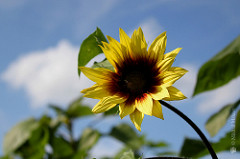

In [67]:
# checking to see if the images get displayed
sunflower = list(data_dir.glob("sunflower/*"))
PIL.Image.open(str(sunflower[0])) # checking first image in sunflower folder

### Creating and splitting the data set using keras utilities  

In [73]:
# I will have a few parameters that can change within the function these will include batch size, image width and height
# I will split the data in to a train at 80% and val 

def train_test_split(batch_size, img_width, img_height):

    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split = 0.2,
        subset = "training",
        seed = 123,
        image_size = (img_width, img_height),
        batch_size = batch_size)
    
    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split = 0.2,
        subset = "validation",
        seed = 123,
        image_size = (img_width, img_height),
        batch_size = batch_size)
    
    # cardinality will now calculate the size of the validation dataset so that I can half it for the test dataset
    val_batches = tf.data.experimental.cardinality(val_ds)
    test_size = val_batches // 2 # test df is half of validation

    # Will now create the test dataset by taking half of the validation data set
    test_ds = val_ds.take(test_size)

    # Adjusting the validation so that it will skip the test dataset
    val_ds = val_ds.skip(test_size)

    return train_ds, val_ds, test_ds


In [74]:
# testing the function with batchsize 32, height 180 and 180
train_ds, val_ds, test_ds = train_test_split(32,180,180)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [70]:
# checking to see the sizes of the train, val and test sets and at what shape they are

print("Training Dataset:")
print("Number of batches:", len(train_ds))
print("Shape of a single batch:", train_ds.element_spec)

print("\nValidation Dataset:")
print("Number of batches:", len(val_ds))
print("Shape of a single batch:", val_ds.element_spec)

print("\nTest Dataset:")
print("Number of batches:", len(test_ds))
print("Shape of a single batch:", test_ds.element_spec)
  

Training Dataset:
Number of batches: 108
Shape of a single batch: (TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Validation Dataset:
Number of batches: 14
Shape of a single batch: (TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Test Dataset:
Number of batches: 13
Shape of a single batch: (TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [75]:
# I need to also add class names so that the data has labels

class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


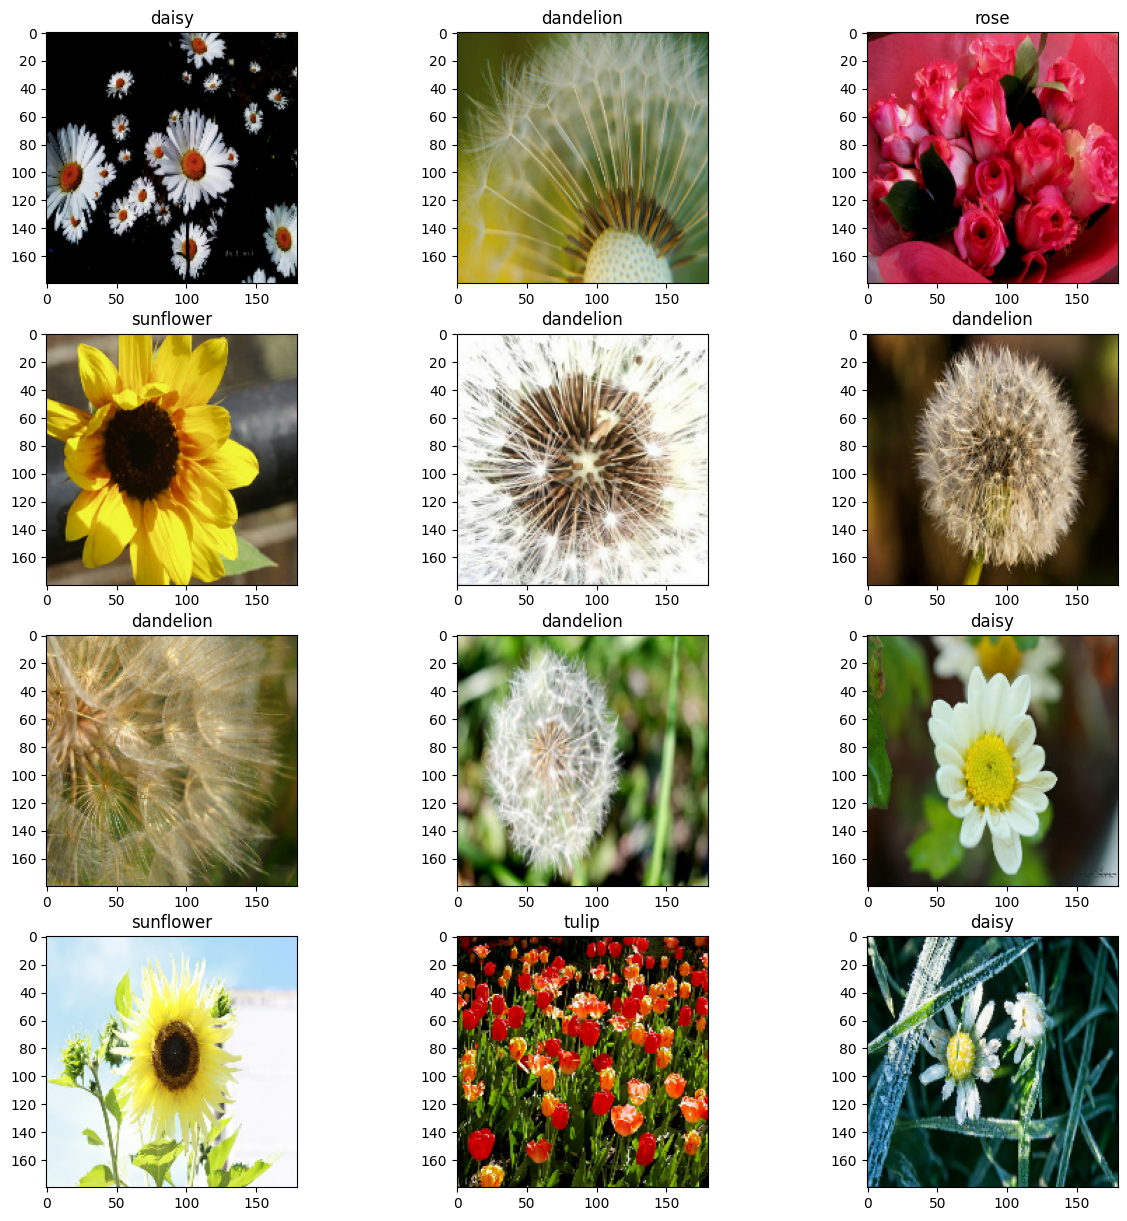

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
for images, labels in train_ds.take(1):
    for i in range (12):
        ax = plt.subplot(4,3, i +1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        